In [1]:
!pip install timm

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Obtaining dependency information for timm from https://files.pythonhosted.org/packages/01/a5/eeb717242343d9ca34e7de554a6c08d96a0cfc7005ece4f847b1753581a6/timm-0.9.12-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 15.7 MB/s eta 0:00:00
  Obtaining dependency information for huggingface-hub from https://files.pythonhosted.org/packages/7f/c4/adcbe9a696c135578cabcbdd7331332daad4d49b7c43688bc2d36b3a47d2/huggingface_hub-0.16.4-py3-none-any.whl.metadata
  Obtaining dependency information for safetensors from https://files.pythonhosted.org/packages/71/04/19d2bf478637996b15371df6279c481d9229b73cc67ccd45a0483da72c00/safetensors-0.4.4-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/00/45/

In [17]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.models.vision_transformer import VisionTransformer
import timm
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim import Adam
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np

In [18]:
mpl.rcParams['figure.dpi'] = 300
sns.set_theme()
sns.set_style("ticks")

# Training

## Setup

In [19]:
# Inputs

df_train_path = 'df_train.csv'
df_val_path  = 'df_val.csv'
df_test_path  = 'df_test.csv'
distort_img_path = 'distorted_crosswalk_images_crop'
num_epochs_for_today = 10
checkpoint_path = 'ViT_cuda_weights/ViT_Classify_Checkpoint.pth.tar'

In [20]:
df_train_full = pd.read_csv(df_train_path)
df_val_full = pd.read_csv(df_val_path)
df_test_full = pd.read_csv(df_test_path)

df_train = df_train_full[["id2","level"]]
df_val = df_val_full[["id2","level"]]
df_test = df_test_full[["id2","level"]]

In [21]:
# Define the Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the Custom Dataset Class
class CrosswayDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.dataframe.iloc[idx, 0]) + '.jpg')
        image = Image.open(img_name).convert('RGB')
        label = int(self.dataframe.iloc[idx, 1])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
def load_checkpoint(filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    start_epoch = checkpoint['epoch']
    return start_epoch

In [22]:
# Create Dataset Objects and DataLoaders
train_dataset = CrosswayDataset(dataframe=df_train, root_dir=distort_img_path, transform=transform)
val_dataset = CrosswayDataset(dataframe=df_val, root_dir=distort_img_path, transform=transform)
test_dataset = CrosswayDataset(dataframe=df_test, root_dir=distort_img_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Begin training

In [8]:
# Load the pretrained Vision Transformer model
model_name = 'vit_base_patch16_224'  # You can choose other ViT models available in timm
model = timm.create_model(model_name, pretrained=True)

model.head = nn.Linear(in_features=model.head.in_features, out_features=99)

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")  # Add this line to check if GPU is being used
model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Load checkpoint if it exists
if os.path.exists(checkpoint_path):
    start_epoch = load_checkpoint(checkpoint_path)
    print(f"Resuming training from epoch {start_epoch + 1}")
else:
    start_epoch = 0

# Training loop
num_epochs = start_epoch + num_epochs_for_today

training_loss_list = []
validation_loss_list = []

for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    
    # Training phase
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        
        # Update the progress bar
        progress_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_dataset)
    training_loss_list.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}] Training Loss: {epoch_loss:.4f}')
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False)
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            
            # Update the progress bar
            progress_bar.set_postfix(loss=loss.item())
    
    val_loss /= len(val_dataset)
    validation_loss_list.append(val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}] Validation Loss: {val_loss:.4f}')
    
    # Save the model and optimizer states for this epoch
    checkpoint = {
        'epoch': epoch + 1,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict()
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch+1}")

    # Save the model weights separately for this epoch
    model_save_path = os.path.join(f'ViT_cuda_weights/vit_classi_epoch_{epoch}.pth') #############################################
    torch.save(model.state_dict(), model_save_path)
    print(f'Model saved to {model_save_path}')

Using device: cuda
Resuming training from epoch 20


Epoch [20/20] Training Loss: 0.7042


Epoch [20/20] Validation Loss: 2.6432
Checkpoint saved at epoch 20
Model saved to ViT_weights/classi/vit_classi_epoch_20.pth


# Inference

In [10]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the pretrained AlexNet model
model_name = 'vit_base_patch16_224'  # You can choose other ViT models available in timm
model = timm.create_model(model_name, pretrained=True)

# Modify the classifier to output 18 classes
model.head = nn.Linear(in_features=model.head.in_features, out_features=99)

# Load the model weights
model_path = 'ViT_cuda_weights/vit_classi_epoch_17.pth'  ############# Select your trained model weights
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

Using device: cuda


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

## Testing on 1 image

In [11]:
# Define the image transformations (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to perform inference and get probabilities
def predict_image(image_path, model, transform, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        probabilities = torch.round(probabilities * 100) / 100  # Round to two decimal places
        predicted_class = torch.argmax(probabilities, dim=1)

    return predicted_class.item(), probabilities.cpu().numpy().flatten()

In [12]:
# Path to the image you want to infer
test_img_path = os.path.join(distort_img_path, str(df_test.iloc[0, 0]) + '.jpg')

# Perform inference
predicted_class, probabilities = predict_image(test_img_path, model, transform, device)

# Print the predicted class and probabilities
print(f'Ground truth class: {df_test.iloc[0,1]}')
print(f'Predicted class: {predicted_class}')
print(f'Probabilities for each class: {probabilities}')

Ground truth class: 76
Predicted class: 76
Probabilities for each class: [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.02 0.   0.   0.07 0.04
 0.   0.07 0.16 0.07 0.06 0.04 0.29 0.08 0.   0.   0.04 0.04 0.   0.
 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.  ]


## Testing on `test_loader`

### Predicted levels, Predicted k, Percentage error

In [90]:
test_loader

In [ ]:
# Given array
k_list = np.linspace(1e-6, 1e-4, 100)

# Initialize a list to store the averages
k_mean = []

# Loop through the array starting from the second element
for i in range(1, len(k_list)):
    mean = (k_list[i] + k_list[i-1]) / 2
    k_mean.append(mean)

# Convert the list to a numpy array (optional)
k_mean = np.array(k_mean)

print(k_mean)

In [91]:
# Assuming the model is already loaded and test_dataset is defined
model.eval()

# Initialize lists to store true labels, predictions, and k predictions
all_labels = []
all_preds = []
all_k_preds = []

# Inference on the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        
        # Compute probabilities using softmax
        probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()

        # Predict class with max probability
        _, preds = torch.max(outputs, 1)

        # Compute k_predictions using np.dot(k_mean, probabilities) for each image
        k_preds = np.dot(probabilities, k_mean)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_k_preds.extend(k_preds)

In [92]:
# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_k_preds = np.array(all_k_preds)

In [93]:
df_test_report = df_test.copy(deep=True)
df_test_report["level_preds"] = all_preds
df_test_report["k_gt"] = df_test_full["k"]
df_test_report["k_preds"] = all_k_preds
df_test_report

,id2,level,level_preds,k_gt,k_preds
0,2066703,76,77,0.000078,0.000075
1,2074905,61,64,0.000062,0.000064
2,2022038,60,63,0.000061,0.000065
3,2060686,98,86,0.000100,0.000089
4,2004094,35,35,0.000036,0.000037
...,...,...,...,...,...
9895,2021815,35,35,0.000037,0.000037
9896,2065463,24,25,0.000025,0.000027
9897,2011739,57,56,0.000058,0.000057
9898,2018046,28,29,0.000030,0.000030


In [94]:
# Assuming your DataFrame is named 'df'
# Calculate the percentage error for each row
df_test_report['percentage_error'] = 100 * abs(df_test_report['k_gt'] - df_test_report['k_preds']) / df_test_report['k_gt']

# Compute the average percentage error across all rows
average_percentage_error = df_test_report['percentage_error'].mean()

print("average_percentage_error =", average_percentage_error)

df_test_report

average_percentage_error = 4.570586075843369


,id2,level,level_preds,k_gt,k_preds,percentage_error
0,2066703,76,77,0.000078,0.000075,4.036056
1,2074905,61,64,0.000062,0.000064,1.859140
2,2022038,60,63,0.000061,0.000065,6.057480
3,2060686,98,86,0.000100,0.000089,10.484807
4,2004094,35,35,0.000036,0.000037,1.889378
...,...,...,...,...,...,...
9895,2021815,35,35,0.000037,0.000037,1.608561
9896,2065463,24,25,0.000025,0.000027,5.484099
9897,2011739,57,56,0.000058,0.000057,1.644265
9898,2018046,28,29,0.000030,0.000030,1.525673


### Classification Report, Confusion Matrix

In [74]:
# Generate the classification report
class_report = classification_report(all_labels, all_preds, digits=4)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0     0.5818    0.3200    0.4129       100
           1     0.3672    0.4700    0.4123       100
           2     0.4167    0.4000    0.4082       100
           3     0.5410    0.6600    0.5946       100
           4     0.4444    0.4800    0.4615       100
           5     0.4643    0.5200    0.4906       100
           6     0.4576    0.2700    0.3396       100
           7     0.4375    0.5600    0.4912       100
           8     0.4900    0.4900    0.4900       100
           9     0.4404    0.4800    0.4593       100
          10     0.4217    0.3500    0.3825       100
          11     0.4574    0.4300    0.4433       100
          12     0.4141    0.5300    0.4649       100
          13     0.3391    0.3900    0.3628       100
          14     0.3182    0.1400    0.1944       100
          15     0.3917    0.4700    0.4273       100
          16     0.4853    0.3300    0.3929       100
    

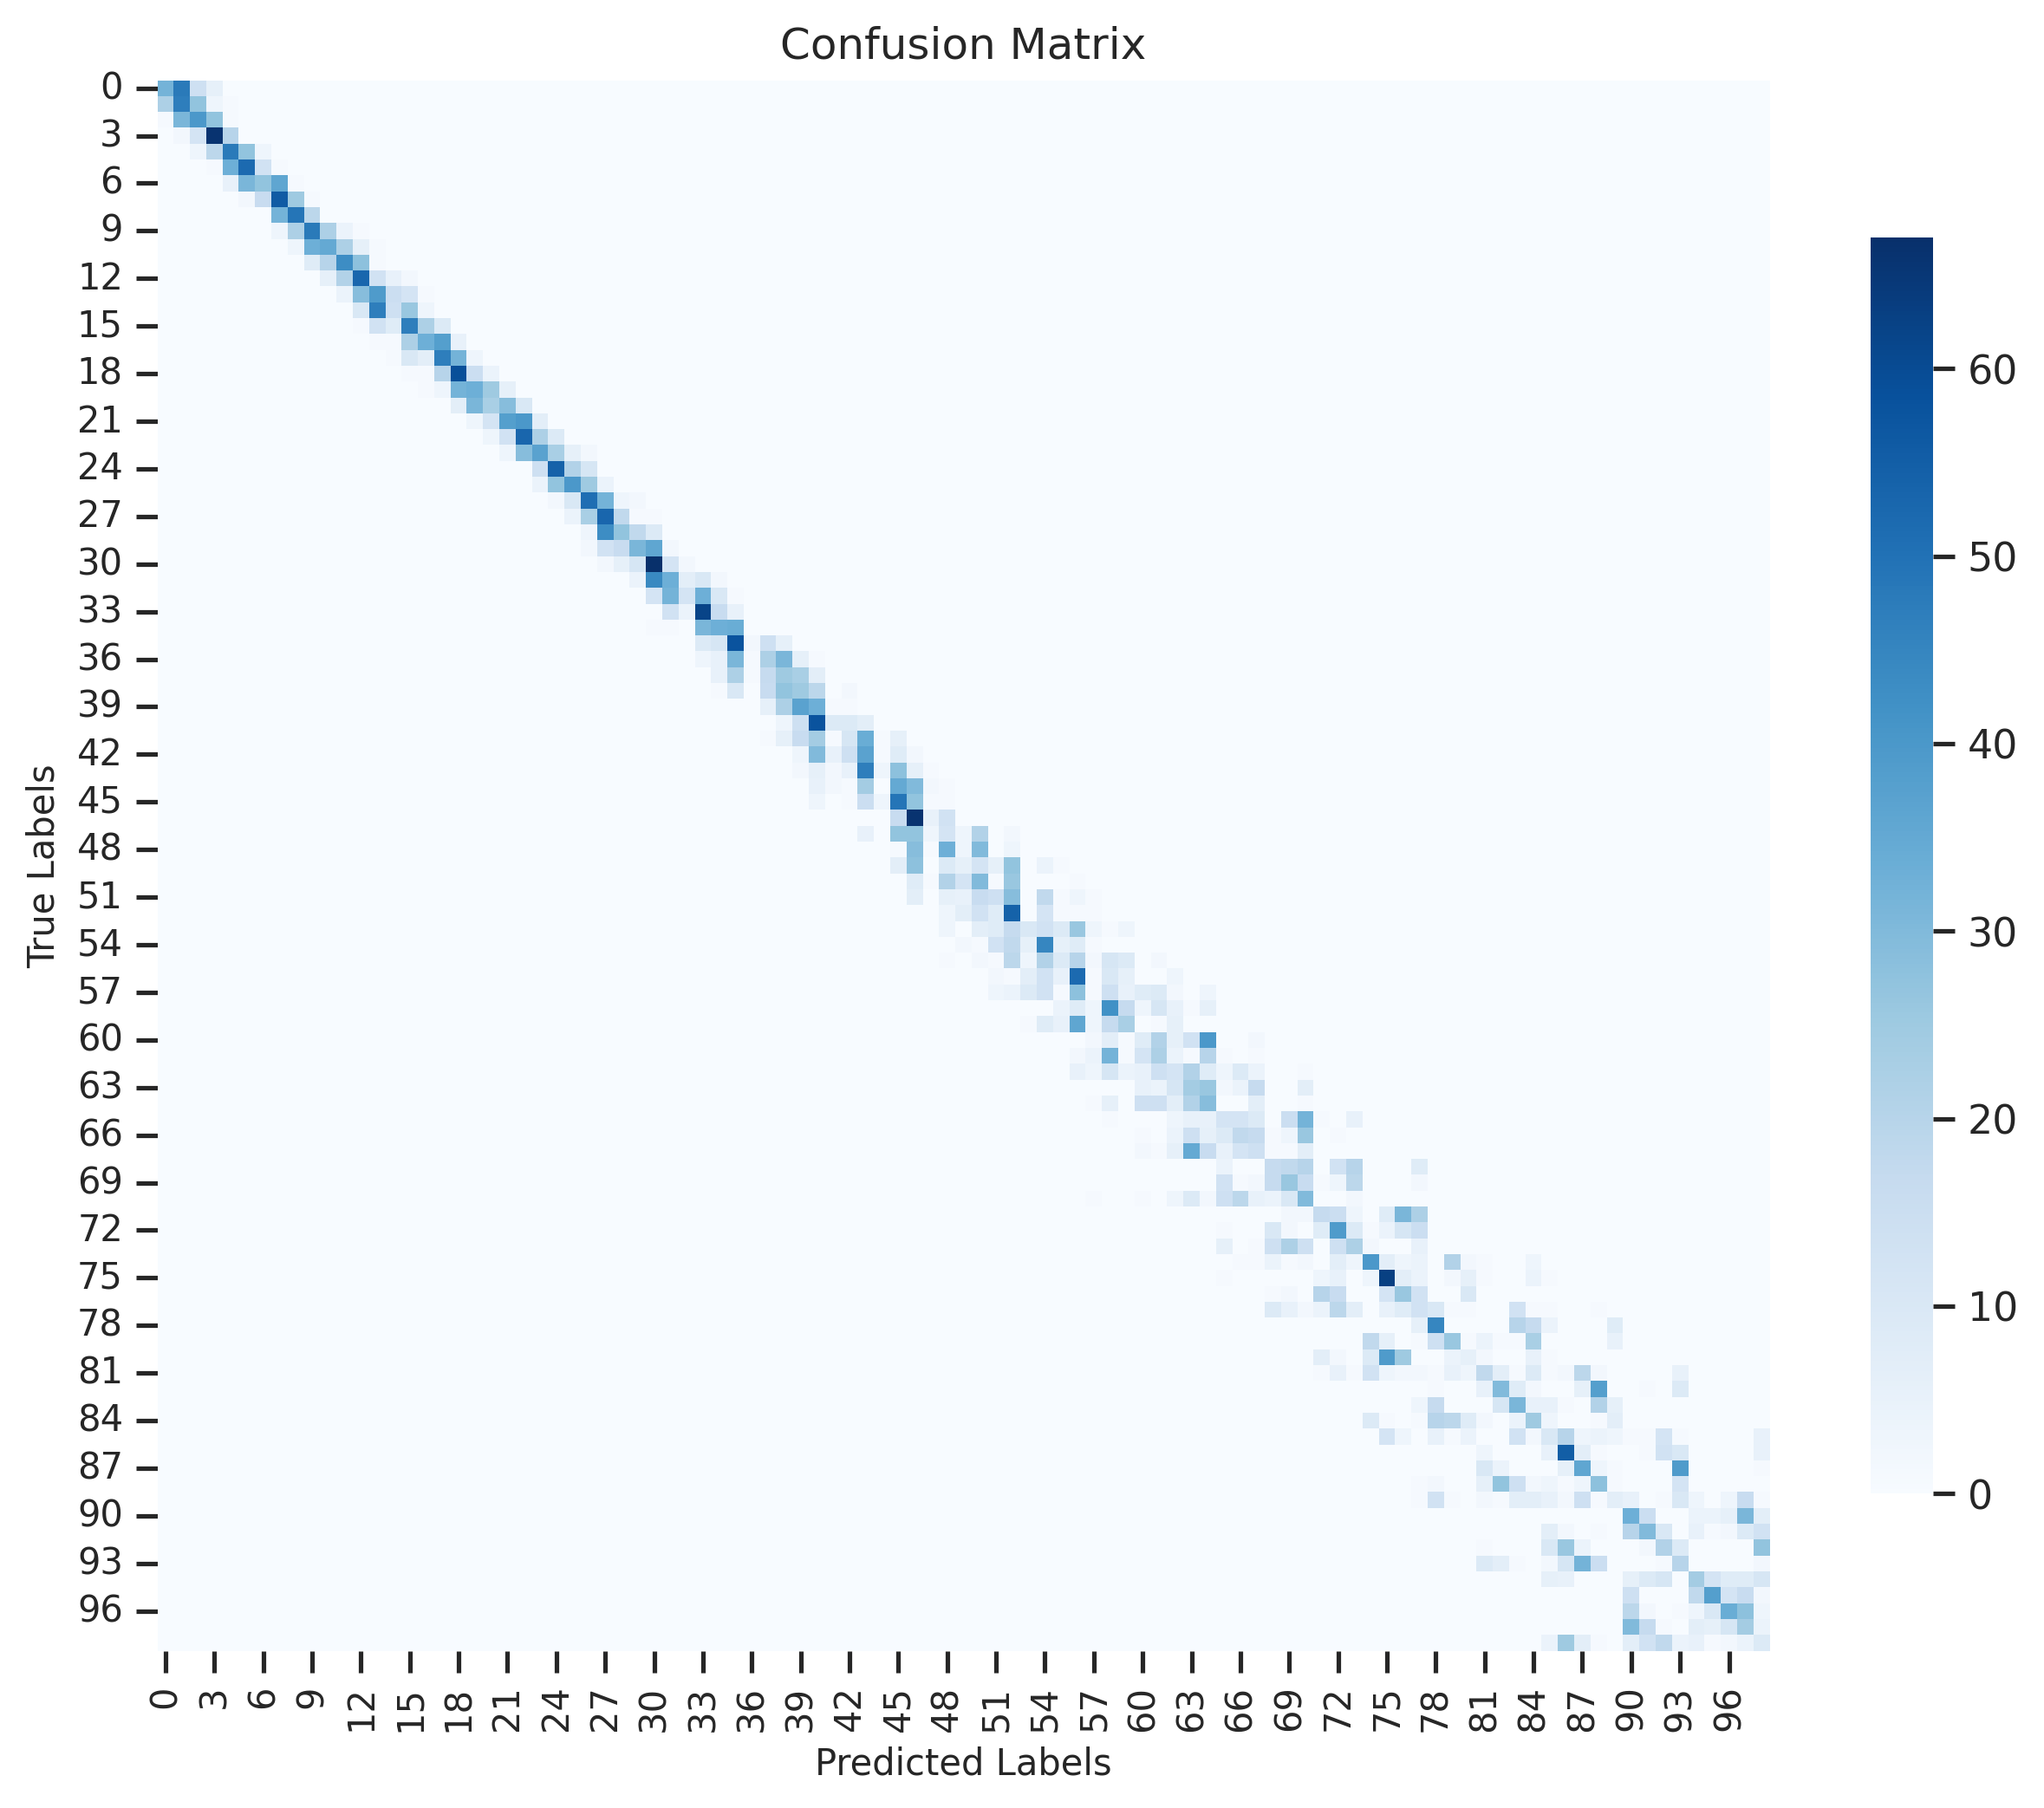

In [75]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)


# Plot the confusion matrix
plt.figure(figsize=(10, 8))

# Create the heatmap with no annotations and add color bar on the right
sns.heatmap(conf_matrix, annot=False, cmap='Blues', cbar=True, cbar_kws={"shrink": 0.8})

# Set the title and labels with reduced font sizes
plt.title('Confusion Matrix', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=10)
plt.ylabel('True Labels', fontsize=10)

# Ensure tick labels are visible with reduced font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

## All at once

In [23]:
# Given array
k_list = np.linspace(1e-6, 1e-4, 100)

# Initialize a list to store the averages
k_mean = []

# Loop through the array starting from the second element
for i in range(1, len(k_list)):
    mean = (k_list[i] + k_list[i-1]) / 2
    k_mean.append(mean)

# Convert the list to a numpy array (optional)
k_mean = np.array(k_mean)

print(k_mean)

[1.50e-06 2.50e-06 3.50e-06 4.50e-06 5.50e-06 6.50e-06 7.50e-06 8.50e-06
 9.50e-06 1.05e-05 1.15e-05 1.25e-05 1.35e-05 1.45e-05 1.55e-05 1.65e-05
 1.75e-05 1.85e-05 1.95e-05 2.05e-05 2.15e-05 2.25e-05 2.35e-05 2.45e-05
 2.55e-05 2.65e-05 2.75e-05 2.85e-05 2.95e-05 3.05e-05 3.15e-05 3.25e-05
 3.35e-05 3.45e-05 3.55e-05 3.65e-05 3.75e-05 3.85e-05 3.95e-05 4.05e-05
 4.15e-05 4.25e-05 4.35e-05 4.45e-05 4.55e-05 4.65e-05 4.75e-05 4.85e-05
 4.95e-05 5.05e-05 5.15e-05 5.25e-05 5.35e-05 5.45e-05 5.55e-05 5.65e-05
 5.75e-05 5.85e-05 5.95e-05 6.05e-05 6.15e-05 6.25e-05 6.35e-05 6.45e-05
 6.55e-05 6.65e-05 6.75e-05 6.85e-05 6.95e-05 7.05e-05 7.15e-05 7.25e-05
 7.35e-05 7.45e-05 7.55e-05 7.65e-05 7.75e-05 7.85e-05 7.95e-05 8.05e-05
 8.15e-05 8.25e-05 8.35e-05 8.45e-05 8.55e-05 8.65e-05 8.75e-05 8.85e-05
 8.95e-05 9.05e-05 9.15e-05 9.25e-05 9.35e-05 9.45e-05 9.55e-05 9.65e-05
 9.75e-05 9.85e-05 9.95e-05]


In [24]:
# Define the image transformations (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to perform inference and get probabilities
def predict_image(image_path, model, transform, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        predicted_class = torch.argmax(probabilities, dim=1)

    return predicted_class.item(), probabilities.cpu().numpy().flatten()

def all_at_once(model_path):
    
    # Define the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load the pretrained AlexNet model
    model_name = 'vit_base_patch16_224'  # You can choose other ViT models available in timm
    model = timm.create_model(model_name, pretrained=True)

    # Modify the classifier to output 18 classes
    model.head = nn.Linear(in_features=model.head.in_features, out_features=99)

    # Load the model weights
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    
    # Initialize lists to store true labels, predictions, and k predictions
    all_labels = []
    all_preds = []
    all_k_preds = []

    # Inference on the test dataset
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            # Compute probabilities using softmax
            probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()

            # Predict class with max probability
            _, preds = torch.max(outputs, 1)

            # Compute k_predictions using np.dot(k_mean, probabilities) for each image
            k_preds = np.dot(probabilities, k_mean)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_k_preds.extend(k_preds)
    
    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_k_preds = np.array(all_k_preds)
    df_test_report = df_test.copy(deep=True)
    df_test_report["level_preds"] = all_preds
    df_test_report["k_gt"] = df_test_full["k"]
    df_test_report["k_preds"] = all_k_preds
    df_test_report['percentage_error'] = 100 * abs(df_test_report['k_gt'] - df_test_report['k_preds']) / df_test_report['k_gt']

    # Compute the average percentage error across all rows
    average_percentage_error = df_test_report['percentage_error'].mean()

    return round(average_percentage_error,4)

In [25]:
average_percentage_error_list = []

for i in range(11,21):
    model_path = f"ViT_cuda_weights/vit_classi_epoch_{i}.pth"
    average_percentage_error = all_at_once(model_path)
    average_percentage_error_list.append(average_percentage_error)
    print(f"Epoch {i}: average_percentage_error = {average_percentage_error}")

average_percentage_error_list

Using device: cuda
Epoch 11: average_percentage_error = 5.8301
Using device: cuda
Epoch 12: average_percentage_error = 5.7384
Using device: cuda
Epoch 13: average_percentage_error = 5.6868
Using device: cuda
Epoch 14: average_percentage_error = 5.5775
Using device: cuda
Epoch 15: average_percentage_error = 5.7668
Using device: cuda
Epoch 16: average_percentage_error = 5.6091
Using device: cuda
Epoch 17: average_percentage_error = 5.8493
Using device: cuda
Epoch 18: average_percentage_error = 5.5679
Using device: cuda
Epoch 19: average_percentage_error = 5.8629
Using device: cuda
Epoch 20: average_percentage_error = 5.9523


[5.8301,
 5.7384,
 5.6868,
 5.5775,
 5.7668,
 5.6091,
 5.8493,
 5.5679,
 5.8629,
 5.9523]